<a href="https://colab.research.google.com/github/Destructor169/ES670MM/blob/main/labs/ES670MM_Assignment1_The_Signal_Recovery_Initiative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project AETHER: The Signal Recovery Initiative

**Role:** Data Forensics Officer
**Mission Status:** CRITICAL \
**Location:** Lunar Forward Base, Mission Control
**Date:** January 29, 2140

---

### Mission Briefing

**Welcome, Officer.**

The autonomous research station **AETHER**, located in the frozen dark of the Kuiper Belt, has gone silent. Yesterday, a burst of raw, corrupted telemetry data finally pierced the static. The transmission is fragmented:
1.  **Text Logs:** Riddled with signal dropouts (missing words).
2.  **Visual Feeds:** Too bandwidth-heavy to decrypt in real-time.

### The Commander's Directive
> *"You are the last line of defense between knowledge and oblivion. Your orders are to use **Matrix Methods** to clean, decode, and compress the signal. We need to read the logs and see the images before the transmission fades forever."*

### Protocol Warning
> *"Be warned: The system validates every line of code. Officers found using 'Ghost Scripts'—unauthorized or plagiarized algorithms—will have their clearance revoked immediately. In Data Forensics, there is no room for borrowed answers. Only your own logic can decrypt the truth."*

**The signal is waiting...**
**Initialize Task 1.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Task 1: The Corrupted Logbook (Contextual Word Recovery) - 4 marks

##  Objective
Restore missing words (`**`) in corrupted sentences using **contextual vector similarity** and **linear algebra**, without using any pretrained language models.

---

##  The Intelligence Report
A long-running text generation system aboard a research station suffered memory corruption after a cosmic radiation event. As a result, individual words in log entries were replaced with the symbol `**`.

You are provided with a **large archive of clean historical sentences **.  
Your mission is to **mathematically infer** the missing word using only this archive.

---


##  The Strategy
To recover a missing word, your system must:

1. **Build a Bag-of-Words matrix**
   - Rows represent  documents
   - Columns represent vocabulary terms

2. **Construct a query vector**
   - Ignore the missing word (`**`)
   - Count all remaining words in the corrupted sentence

3. **Retrieve relevant documents**
   - Use cosine similarity to find the most similar historical documents
   - Restrict inference to only these documents

4. **Extract local context**
   - Identify words surrounding the missing position
   - Ignore stopwords and the masked token

5. **Score candidate words**
   - For each vocabulary word:
     - Extract its frequency vector across retrieved documents
     - Compare it with the context signal using cosine similarity

6. **Predict the missing word**
   - Rank candidates by similarity score
   - Return the top-K most likely words

All code must be written from scratch using only **NumPy** (no other libraries allowed).

---


In [2]:
import numpy as np
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def clean_text(text):
    text = text.strip()
    text = re.sub(r'\.\s*$', '', text)
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def load_documents(txt_path):
    with open(txt_path, "r", encoding="utf-8") as f:
        docs = [clean_text(line) for line in f if line.strip()]
    return docs


In [4]:
def build_bow(documents):
    """
    Construct a Bag-of-Words (BoW) representation from a list of documents.

    Parameters
    ----------
    documents : list of str
        A list of preprocessed (cleaned) documents, where each document
        is a whitespace-separated string of tokens.

    Returns
    -------
    X : np.ndarray of shape (num_docs, vocab_size)
        Document-term matrix where X[i, j] denotes the frequency of the
        j-th vocabulary word in the i-th document.

    vocab : list of str
        Sorted list of all unique words appearing in the corpus.

    vocab_dict : dict
        Dictionary mapping each vocabulary word to its corresponding
        column index in the document-term matrix.
    """

    # --------------------------------------------------
    # Step 1: Tokenize all documents and build vocabulary
    # --------------------------------------------------

    all_tokens = []

    tokenized_docs = []

    for doc in documents:
        tokens = doc.split()
        tokenized_docs.append(tokens)
        all_tokens.extend(tokens)

    # Unique sorted vocabulary
    vocab = sorted(list(set(all_tokens)))

    # Mapping from word -> column index
    vocab_dict = {word: idx for idx, word in enumerate(vocab)}

    # --------------------------------------------------
    # Step 2: Initialize Document-Term Matrix
    # --------------------------------------------------

    num_docs = len(documents)
    vocab_size = len(vocab)

    X = np.zeros((num_docs, vocab_size), dtype=np.int32)

    # --------------------------------------------------
    # Step 3: Fill frequencies
    # --------------------------------------------------

    for i, tokens in enumerate(tokenized_docs):
        for word in tokens:
            j = vocab_dict[word]
            X[i, j] += 1

    return X, vocab, vocab_dict

In [5]:
def cosine_similarity(a, b):
    """
    Compute cosine similarity between two vectors.
    """

    # Convert to float arrays to avoid integer overflow
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)

    # Dot product
    dot = np.dot(a, b)

    # Euclidean norms
    norm_a = np.sqrt(np.sum(a ** 2))
    norm_b = np.sqrt(np.sum(b ** 2))

    # Avoid division by zero
    if norm_a == 0 or norm_b == 0:
        return 0.0

    return dot / (norm_a * norm_b)

In [6]:
def get_context(tokens, window=4):
    """
    Given tokenized sentence containing '**',
    return a set of surrounding context words.
    """

    # Find the index of the masked token
    masked_idx = None
    for i, tok in enumerate(tokens):
        if tok == "**":
            masked_idx = i
            break

    if masked_idx is None:
        return set()

    context = set()

    # Define left and right window bounds
    start = max(0, masked_idx - window)
    end = min(len(tokens), masked_idx + window + 1)

    for i in range(start, end):
        tok = tokens[i]

        # Skip masked token and stopwords
        if tok == "**":
            continue
        if tok in stop_words:
            continue

        context.add(tok)

    return context

In [7]:
def retrieve_top_documents(X, q, k):
    """
    Input:
        X -> document-term matrix
        q -> query vector
        k -> number of top documents
    Output:
        indices of top-k documents
    """

    similarities = []

    # Compute cosine similarity between query and each document
    for i in range(X.shape[0]):
        sim = cosine_similarity(X[i], q)
        similarities.append(sim)

    similarities = np.array(similarities)

    # Get indices of top-k similarities (sorted descending)
    top_k_idx = np.argsort(similarities)[::-1][:k]

    return top_k_idx

In [8]:
## Do not make changes here
def score_candidates(
    X,
    vocab,
    vocab_dict,
    top_doc_ids,
    context,
    cosine_fn
):
    """
    Uses ONLY:
      - word vectors from top documents
      - context co-occurrence signal
      - cosine similarity implemented by students
    """

    context_vec = np.zeros(len(top_doc_ids))

    for i, d in enumerate(top_doc_ids):
        for w in context:
            if w in vocab_dict:
                context_vec[i] += X[d][vocab_dict[w]]

    scores = np.zeros(len(vocab))

    for v in range(len(vocab)):
        word_vec = X[top_doc_ids, v]

        scores[v] = cosine_fn(word_vec, context_vec)

    return scores


In [9]:
def decode_missing_word(
    sentence,
    X,
    vocab,
    vocab_dict,
    top_docs=20,
    top_words=5,
    window=4
):
    tokens = sentence.split()

    # --- build query vector ---
    q = np.zeros(len(vocab))
    for w in tokens:
        if w != "**" and w in vocab_dict:
            q[vocab_dict[w]] += 1

    # --- retrieve top documents ---
    top_doc_ids = retrieve_top_documents(X, q, top_docs)

    # --- get context ---
    context = get_context(tokens, window)

    # --- scoring ---
    scores = score_candidates(
        X,
        vocab,
        vocab_dict,
        top_doc_ids,
        context,
        cosine_similarity
    )


    for w in tokens:
        if w in vocab_dict:
            scores[vocab_dict[w]] = 0

    for w, i in vocab_dict.items():
        if w in stop_words:
            scores[i] = 0

    top_idx = np.argsort(scores)[-top_words:][::-1]
    return [vocab[i] for i in top_idx]

In [10]:
docs = load_documents("/content/drive/MyDrive/ES670MM/dataset/A/text/sentences.txt")

X, vocab, vocab_dict = build_bow(docs)

test_sentences = [
    "They decided to plant an ** of cotton candy.",
    "** make great weapons when water balloons aren’t available.",
    "The tumbleweed refused to tumble but was more than ** to prance.",
    "Nancy thought the best way to create a ** home was to line it with barbed wire.",
    "The underground ** was filled with chips and candy.",
    "The dead trees ** to be ignited by the smallest spark and seek their revenge.",
    "The overpass went under the ** and into a secret world.",
    "His get rich quick scheme was to grow a ** farm.",
    "Siri became ** when we reused to follow her directions.",
    "She found it strange that people use their cellphones to actually ** to one another.",
]

for i, sentence in enumerate(test_sentences, 1):
    predictions = decode_missing_word(
        sentence,
        X,
        vocab,
        vocab_dict
    )

    print(f"\nSentence {i}: {sentence}")
    print("Top 5 predictions:", predictions)


Sentence 1: They decided to plant an ** of cotton candy.
Top 5 predictions: ['candy', 'orchard', 'red', 'hood', 'home']

Sentence 2: ** make great weapons when water balloons aren’t available.
Top 5 predictions: ['available', 'tomatoes', 'right', 'would', 'trowel']

Sentence 3: The tumbleweed refused to tumble but was more than ** to prance.
Top 5 predictions: ['a', 'zone', 'zombies', 'yr', 'you’re']

Sentence 4: Nancy thought the best way to create a ** home was to line it with barbed wire.
Top 5 predictions: ['wire', 'welcoming', 'nancy', 'cursive', 'succeed']

Sentence 5: The underground ** was filled with chips and candy.
Top 5 predictions: ['bunker', 'candy', 'seen', 'beautiful', 'never']

Sentence 6: The dead trees ** to be ignited by the smallest spark and seek their revenge.
Top 5 predictions: ['revenge', 'waited', 'foretelling', 'forest', 'for']

Sentence 7: The overpass went under the ** and into a secret world.
Top 5 predictions: ['world', 'highway', 'immediately', 'whiskey

### **Analysis Question**
**Why is cosine similarity preferred over Euclidean distance for this task? In what situation could Euclidean distance lead to misleading results?**

## Why Cosine Similarity Is Preferred Over Euclidean Distance

In this task, documents and queries are represented as high-dimensional Bag-of-Words (BoW) vectors whose magnitudes depend on document length and total word counts.

Cosine similarity measures the **angle between two vectors**, not their absolute size:

$$
\text{cosine}(a,b) = \frac{a \cdot b}{\|a\| \, \|b\|}
$$

This makes cosine similarity **scale-invariant**. Two documents that use the same words in similar proportions but have different lengths will still be considered similar.

In contrast, Euclidean distance depends directly on the **absolute differences in coordinates**. Longer documents naturally have larger vector norms and may appear far from shorter but semantically similar ones.

Therefore, cosine similarity is preferred because it focuses on **relative word usage patterns** rather than raw frequency magnitudes.

---

## When Euclidean Distance Can Be Misleading

### Large Differences in Document Length

Consider two documents:

- Document A: `"signal station orbit"`
- Document B: `"signal station orbit orbit orbit orbit"`

Although their semantic content is nearly identical, Document B contains higher word counts.

Euclidean distance between their BoW vectors would be large due to magnitude differences, while cosine similarity would correctly indicate high similarity.

---

### Short Queries Compared with Long Documents

Corrupted queries usually contain very few words.

When a short query vector is compared to a long document vector, Euclidean distance tends to be large simply because the document has many more nonzero entries.

Cosine similarity avoids this problem by normalizing vector lengths.

---

### Sparse High-Dimensional Representations

BoW vectors are sparse and high-dimensional.

In such spaces, Euclidean distance is often dominated by differences in magnitude rather than true semantic alignment.

Cosine similarity is known to perform better for text-based retrieval in sparse vector spaces.

---

## Summary

Cosine similarity is preferred because it:

- is length-normalized  
- is robust to scaling  
- works well in sparse, high-dimensional spaces  
- captures distributional similarity  

Euclidean distance can be misleading when:

- document lengths vary significantly  
- query vectors are much shorter than documents  
- frequency magnitudes dominate the geometry of the space  


#  Task 2: Visual Bandwidth Optimization (Image Segmentation) - 6 marks

**Mission:** Compress the visual feed from the *Aether* station. \
**Objective:** Implement **Vectorized K-Means Clustering** from scratch to quantize image colors.

The *Aether* is trying to send high-resolution images of an "Anomaly," but our bandwidth is limited. We cannot stream millions of colors. We must **quantize** the image, reducing it to just $K$ distinct "channels" (colors) without losing structural info.


In [11]:
# importing all necessary files

from google.colab import drive
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

# Ensure this path matches exactly where you uploaded the 'dataset' folder
base_path = "/content/drive/MyDrive/ES670MM/dataset/A/images"

if os.path.exists(base_path):
    print(f"Secure connection established to: {base_path}")
    files = os.listdir(base_path)
    print(f"Found {len(files)} files in the directory.")
else:
    print(f"Error: Path not found. Please check your folder structure in Drive.")

Secure connection established to: /content/drive/MyDrive/ES670MM/dataset/A/images
Found 12 files in the directory.


## The Matrix Engine (Distance Calculation)

**The Challenge:** Calculating the distance between every pixel and every centroid using **Matrix Broadcasting**. Don't use unnecessary `for` loop because it's too slow for real-time processing.

**Mathematical Identity:**
To calculate the squared Euclidean distance $||X - C||^2$ efficiently, expand the term:
$$||X - C||^2 = ||X||^2 + ||C||^2 - 2(X \cdot C^T)$$

**Your Task:**
Fill in the `get_distances` function.
* **Input:** Matrix $X$ of pixels $(N, 3)$ and Matrix $C$ of centroids $(K, 3)$.
* **Output:** Matrix of distances $(N, K)$.

All code must be written from scratch using only NumPy (no other libraries allowed).

In [12]:
def get_distances(X, centroids):
    """
    Computes Euclidean distance between every row in X and every row in centroids.

    Input:
        X         -> (N, 3)
        centroids -> (K, 3)

    Output:
        dists -> (N, K)
    """

    # X dot C^T  -> (N, K)
    dot_product = X @ centroids.T

    # ||X||^2 for each row -> (N, 1)
    X_squared = np.sum(X ** 2, axis=1, keepdims=True)

    # ||C||^2 for each row -> (1, K)
    C_squared = np.sum(centroids ** 2, axis=1, keepdims=True).T

    # Apply identity: ||X - C||^2 = ||X||^2 + ||C||^2 - 2 X C^T
    dists = X_squared + C_squared - 2 * dot_product

    return dists

## The Clustering Loop (E-Step & M-Step)

**The Challenge:** Now that we can calculate distances efficiently, we need to iterate until the best colors are found.

**Your Task:**
Implement the main K-Means loop in `kmeans_algorithm`.
1.  **E-Step (Expectation):** Assign every pixel to the nearest centroid.
2.  **M-Step (Maximization):** Move the centroid to the average color of its assigned pixels.

In [13]:
def kmeans_algorithm(X, k, max_iters=100):
    """
    K-Means implementation from scratch using numpy matrix operations.
    """

    n_samples, n_features = X.shape

    # Initialize centroids randomly from pixels
    random_indices = np.random.choice(n_samples, k, replace=False)
    centroids = X[random_indices]

    labels = np.zeros(n_samples)

    print(f"Starting K-Means with K={k}...")

    for i in range(max_iters):

        # -------------------------
        # E-STEP: Assignment
        # -------------------------
        dists = get_distances(X, centroids)

        # Assign each pixel to nearest centroid
        new_labels = np.argmin(dists, axis=1)

        # Convergence check
        if np.all(labels == new_labels):
            print(f"  -> Converged at iteration {i}")
            break

        labels = new_labels

        # -------------------------
        # M-STEP: Update
        # -------------------------
        new_centroids = np.zeros((k, n_features))

        for cluster_idx in range(k):

            cluster_points = X[labels == cluster_idx]

            # If cluster is empty, reinitialize randomly
            if len(cluster_points) == 0:
                new_centroids[cluster_idx] = X[np.random.choice(n_samples)]
            else:
                new_centroids[cluster_idx] = np.mean(cluster_points, axis=0)

        centroids = new_centroids

    return centroids, labels

## Execution & Visualization

**The Challenge:** We need to test the compression algorithm on the corrupted feed. We will test different "bandwidths" (Values of K) to find the best trade-off between quality and size.

**Your Task:**
1.  Run the code below.
2.  It will loop through different values of K .
3.  **Observation:** Watch how the image quality changes.

Starting Batch Visualization for 8 images...
Testing Bandwidths: [2, 3, 4, 5, 6, 8, 10]

Processing Feed ID: 5...
Starting K-Means with K=2...
  -> Converged at iteration 8
Starting K-Means with K=3...
  -> Converged at iteration 19
Starting K-Means with K=4...
Starting K-Means with K=5...
Starting K-Means with K=6...
Starting K-Means with K=8...
Starting K-Means with K=10...


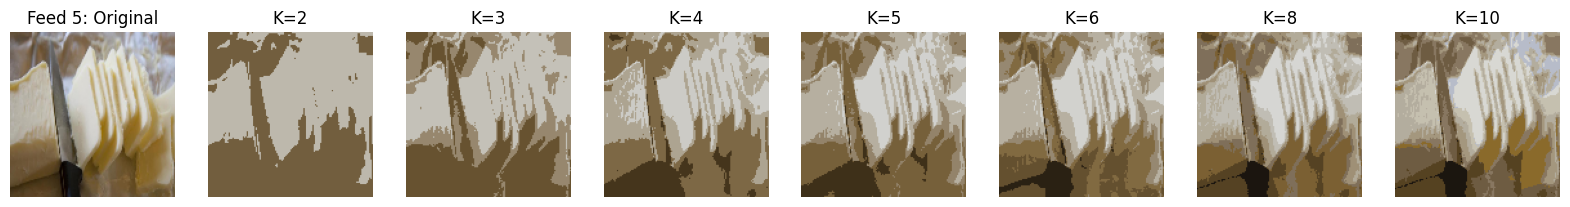


Processing Feed ID: 6...
Starting K-Means with K=2...
  -> Converged at iteration 7
Starting K-Means with K=3...
  -> Converged at iteration 13
Starting K-Means with K=4...
  -> Converged at iteration 14
Starting K-Means with K=5...
  -> Converged at iteration 17
Starting K-Means with K=6...
Starting K-Means with K=8...
Starting K-Means with K=10...


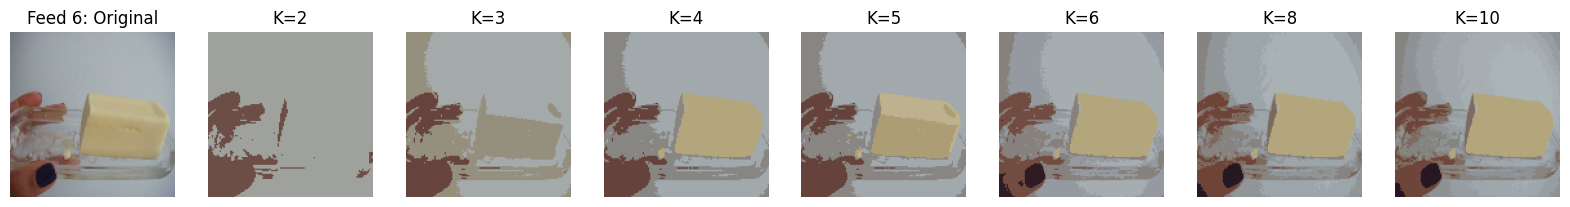


Processing Feed ID: 7...
Starting K-Means with K=2...
  -> Converged at iteration 9
Starting K-Means with K=3...
  -> Converged at iteration 17
Starting K-Means with K=4...
  -> Converged at iteration 14
Starting K-Means with K=5...
Starting K-Means with K=6...
  -> Converged at iteration 28
Starting K-Means with K=8...
  -> Converged at iteration 28
Starting K-Means with K=10...


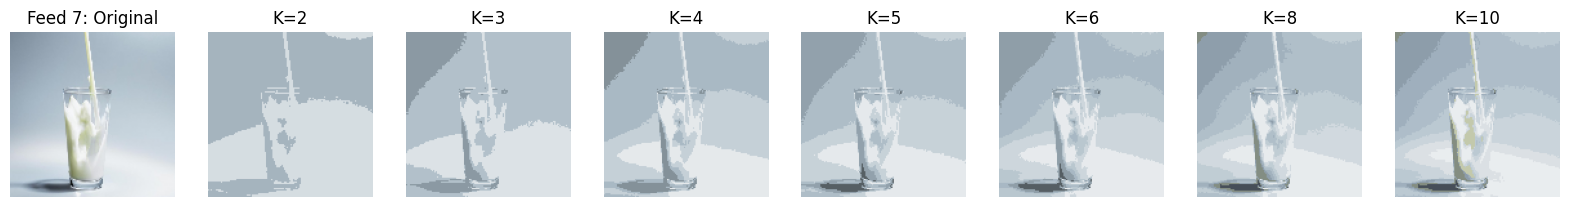


Processing Feed ID: 8...
Starting K-Means with K=2...
  -> Converged at iteration 9
Starting K-Means with K=3...
  -> Converged at iteration 26
Starting K-Means with K=4...
  -> Converged at iteration 24
Starting K-Means with K=5...
  -> Converged at iteration 22
Starting K-Means with K=6...
  -> Converged at iteration 24
Starting K-Means with K=8...
Starting K-Means with K=10...


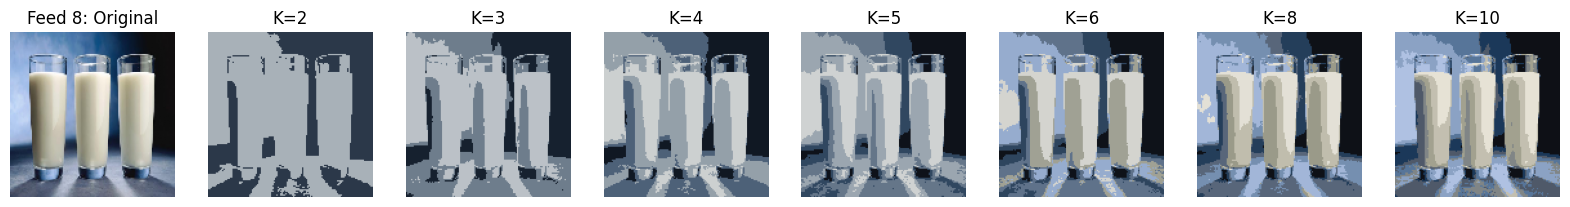


Processing Feed ID: 9...
Starting K-Means with K=2...
  -> Converged at iteration 9
Starting K-Means with K=3...
  -> Converged at iteration 18
Starting K-Means with K=4...
  -> Converged at iteration 22
Starting K-Means with K=5...
  -> Converged at iteration 21
Starting K-Means with K=6...
Starting K-Means with K=8...
Starting K-Means with K=10...


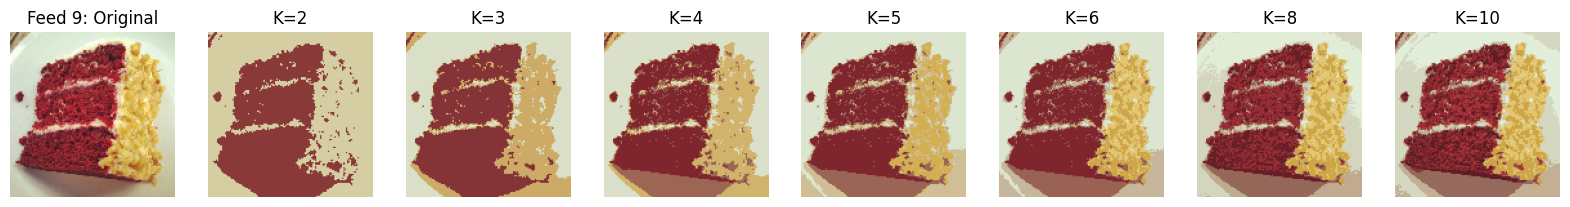


Processing Feed ID: 10...
Starting K-Means with K=2...
  -> Converged at iteration 7
Starting K-Means with K=3...
  -> Converged at iteration 10
Starting K-Means with K=4...
  -> Converged at iteration 23
Starting K-Means with K=5...
Starting K-Means with K=6...
Starting K-Means with K=8...
Starting K-Means with K=10...
  -> Converged at iteration 25


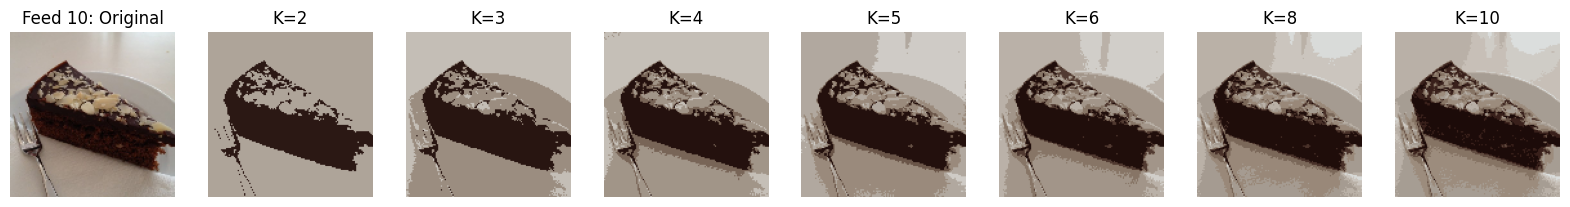


Processing Feed ID: 11...
Starting K-Means with K=2...
  -> Converged at iteration 14
Starting K-Means with K=3...
  -> Converged at iteration 23
Starting K-Means with K=4...
Starting K-Means with K=5...
Starting K-Means with K=6...
Starting K-Means with K=8...
Starting K-Means with K=10...


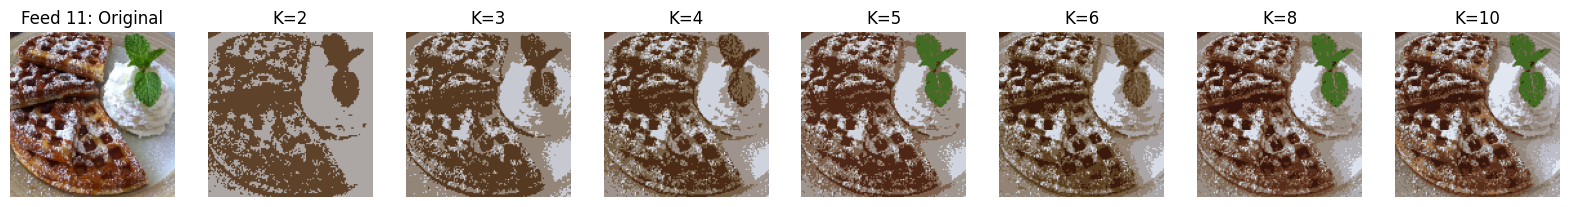


Processing Feed ID: 12...
Starting K-Means with K=2...
  -> Converged at iteration 5
Starting K-Means with K=3...
  -> Converged at iteration 12
Starting K-Means with K=4...
  -> Converged at iteration 16
Starting K-Means with K=5...
Starting K-Means with K=6...
Starting K-Means with K=8...
Starting K-Means with K=10...


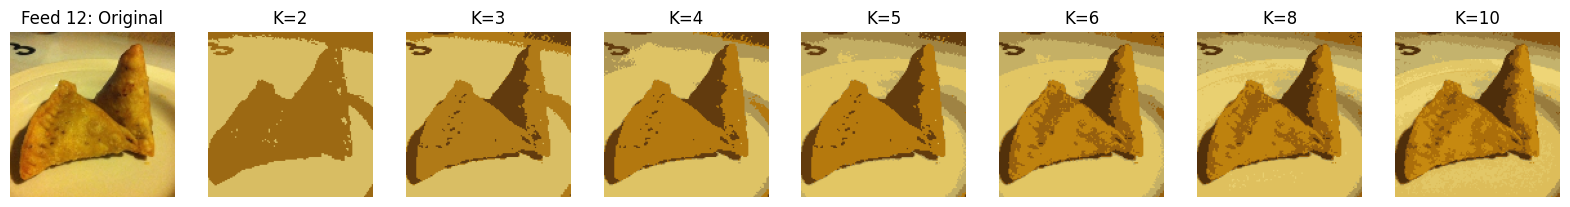


Batch Processing Complete.


In [14]:
# You have 8 images to visualize
visual_ids = [5, 6, 7, 8, 9, 10, 11, 12]

# The specific bandwidths (K) you want to test per image
# You can play with different values of k
bandwidths = [2, 3, 4, 5, 6, 8, 10]

print(f"Starting Batch Visualization for {len(visual_ids)} images...")
print(f"Testing Bandwidths: {bandwidths}")

for img_id in visual_ids:
    try:
        # 1. Load Image
        path = f"{base_path}/image_{img_id}.png"
        if not os.path.exists(path):
            print(f"Warning: File not found: {path}")
            continue

        print(f"\nProcessing Feed ID: {img_id}...")
        image = io.imread(path)

        # Normalize
        image = np.array(image, dtype=np.float64) / 255.0
        if image.shape[2] == 4: image = image[:,:,:3] # Drop Alpha
        h, w, c = image.shape
        X = image.reshape(-1, 3)

        plt.figure(figsize=(20, 4))

        # Plot Original
        plt.subplot(1, len(bandwidths)+1, 1)
        plt.title(f"Feed {img_id}: Original")
        plt.imshow(image)
        plt.axis('off')

        # 3. Loop through Bandwidths
        for i, K in enumerate(bandwidths):
            final_colors, pixel_labels = kmeans_algorithm(X, K, max_iters=30)

            # Reconstruct
            reconstructed_flat = final_colors[pixel_labels.astype(int)]
            reconstructed_image = reconstructed_flat.reshape(h, w, c)

            # Plot Compressed (Subsequent Columns)
            plt.subplot(1, len(bandwidths)+1, i+2)
            plt.title(f"K={K}")
            plt.imshow(reconstructed_image)
            plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"Error processing image {img_id}: {e}")

print("\nBatch Processing Complete.")

## The Optimization (Finding the "Elbow")

**The Challenge:** Visual inspection is subjective. How do we mathematically define the "optimal" number of colors?

We use the **Elbow Method**. We plot the **Inertia** (Total Squared Error) vs. $K$.
* **Inertia Formula:** The sum of squared distances between every pixel and its assigned centroid.
    $$J = \sum_{i=1}^{N} ||x_i - \mu_{z_i}||^2$$
* **Goal:** Find the $K$ where the decrease in error starts to flatten out (diminishing returns).

**Your Task:**
1.  Implement `calculate_inertia` using matrix operations.
2.  Run the loop for $K = 1$ to $12$.
3.  Plot the graph.



In [15]:
def calculate_inertia(X, centroids, labels):
    """
    Calculates the total squared error (Inertia) efficiently.

    Input:
        X         -> (N, 3) pixel matrix
        centroids -> (K, 3)
        labels    -> (N,)

    Output:
        inertia (scalar)
    """

    # Select centroid for each pixel
    assigned_centroids = centroids[labels.astype(int)]

    # Compute squared differences
    squared_diffs = (X - assigned_centroids) ** 2

    # Sum over features, then all pixels
    inertia = np.sum(squared_diffs)

    return inertia

Starting Calibration Sequence...
  > Analyzing Signal 1...
Starting K-Means with K=1...
  -> Converged at iteration 0
Starting K-Means with K=2...
  -> Converged at iteration 8
Starting K-Means with K=3...
  -> Converged at iteration 22
Starting K-Means with K=4...
  -> Converged at iteration 27
Starting K-Means with K=5...
  -> Converged at iteration 29
Starting K-Means with K=6...
  -> Converged at iteration 22
Starting K-Means with K=7...
  -> Converged at iteration 46
Starting K-Means with K=8...
  -> Converged at iteration 42
Starting K-Means with K=9...
  -> Converged at iteration 32
Starting K-Means with K=10...
  -> Converged at iteration 23
Starting K-Means with K=11...
  -> Converged at iteration 37
Starting K-Means with K=12...
  -> Converged at iteration 41
  > Analyzing Signal 2...
Starting K-Means with K=1...
  -> Converged at iteration 0
Starting K-Means with K=2...
  -> Converged at iteration 12
Starting K-Means with K=3...
  -> Converged at iteration 14
Starting K-Mean

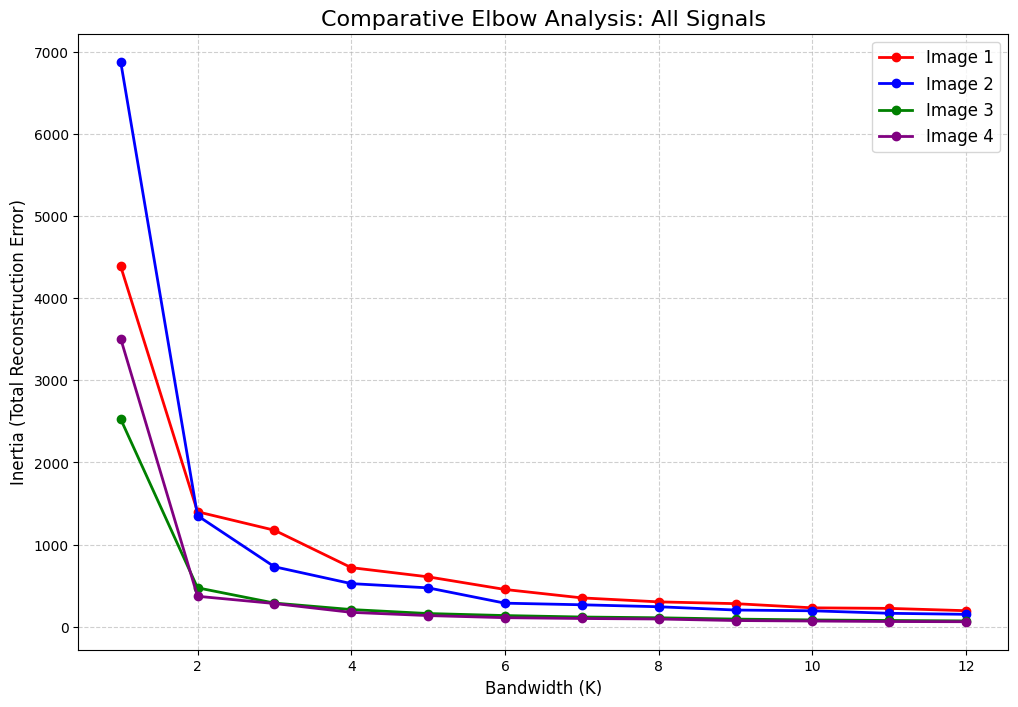

In [16]:
analysis_ids = [1, 2, 3, 4]
max_k = 12

plt.figure(figsize=(12, 8))
plt.title("Comparative Elbow Analysis: All Signals", fontsize=16)
plt.xlabel("Bandwidth (K)", fontsize=12)
plt.ylabel("Inertia (Total Reconstruction Error)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

colors = ['red', 'blue', 'green', 'purple']

print("Starting Calibration Sequence...")

for idx, img_id in enumerate(analysis_ids):
    try:
        # Load Image
        path = f"{base_path}/image_{img_id}.png"
        image = io.imread(path)
        image = np.array(image, dtype=np.float64) / 255.0
        if image.shape[2] == 4: image = image[:,:,:3]
        X = image.reshape(-1, 3)

    except Exception as e:
        print(f"Skipping Image {img_id}: {e}")
        continue

    # Calculate Elbow Curve
    inertias = []
    k_range = range(1, max_k + 1)

    print(f"  > Analyzing Signal {img_id}...")

    for k in k_range:
        # Run Engine
        centroids, labels = kmeans_algorithm(X, k, max_iters=100)

        # Calculate Inertia
        cost = calculate_inertia(X, centroids, labels)

        inertias.append(cost)

    # Plot on the SAME graph
    plt.plot(k_range, inertias, marker='o', linewidth=2,
             color=colors[idx % len(colors)],
             label=f"Image {img_id}")

plt.legend(fontsize=12)
plt.show()

## Critical Analysis

> **Question:**
> From the above generated graph, figure out the optimal value of k for each image? Write your observation on the performance of clustering when K increases from 1 to 15 ?

> Feel free to explore image segmentation for higher values of k and note the observation.s

For each pixel \(x_i\), K-Means assigns it to a centroid \(\mu_{z_i}\).

The total reconstruction error (inertia) is:

$$
J = \sum_{i=1}^{N} \|x_i - \mu_{z_i}\|^2
$$

This measures how much information is lost when pixels are replaced by their cluster colors.

Lower inertia ⇒ better reconstruction but higher bandwidth usage.

The Elbow Method plots \(J\) versus \(K\) to find the point where adding more clusters yields diminishing improvements.

## Critical Analysis

### Optimal Value of \(K\) from the Elbow Curves

From the inertia versus \(K\) plots for Signals 1–4 (tested from \(K = 1\) to \(12\)), all curves exhibit:

- a very sharp decrease from \(K = 1\) to \(K = 2\)  
- a noticeable reduction until approximately \(K \approx 3\) or \(4\)  
- a much slower decline beyond that point  

This behavior indicates diminishing returns as the number of clusters increases.

---

### Mathematical Explanation of the Elbow Shape

K-Means minimizes the objective:

$$
J(K) = \sum_{i=1}^{N} \|x_i - \mu_{z_i}\|^2
$$

When \(K\) is small, each centroid must represent many distinct colors.  
Increasing \(K\) allows centroids to specialize, sharply reducing the squared distances.

However, once dominant color groups are captured, adding more centroids only splits existing clusters into nearby subclusters.  
Because these new centroids lie close to the previous ones, the reduction in \(J(K)\) becomes small, producing the elbow.

---

### Estimated Elbow Locations

| Image (Signal) | Elbow Range |
|---------------|-----------|
| Image 1 | K ≈ 3 to 4 |
| Image 2 | K ≈ 3 to 4 |
| Image 3 | K ≈ 2 to 3 |
| Image 4 | K ≈ 2 to 3 |

Thus, for most images the optimal bandwidth lies around:

$$
K \approx 3 \text{ to } 5
$$

This range captures the major color modes while still maintaining strong compression.

---

---

### Effect of Increasing \(K\) from 1 to 15

#### Small \(K\) (1–2)

- Large regions are forced into a few colors.  
- The variance inside each cluster is high, so \(J(K)\) is large.  
- Images appear strongly posterized.

#### Moderate \(K\) (3–6)

- Centroids begin representing separate foreground and background regions.  
- Within-cluster variance drops rapidly.  
- Edges and object boundaries emerge clearly.  
- This region usually corresponds to the elbow.

#### Large \(K\) (7–15)

- Clusters model finer color gradients.  
- The decrease in inertia becomes slow.  
- Structural content changes little compared to moderate \(K\).

---

### Why the Curves Flatten Mathematically

As \(K\) increases, the marginal improvement:

$$
\Delta J = J(K-1) - J(K)
$$

shrinks.

Early centroids reduce large errors from coarse color grouping.  
Later centroids only reduce small residual errors from subtle shading, so the slope of the curve decreases.

This produces the characteristic flattening after the elbow point.

---

### Summary

- Inertia decreases monotonically with \(K\).  
- The elbow typically appears between \(K = 3\) and \(5\).  
- Below this range the model underfits.  
- Above this range improvements are marginal relative to added complexity.

This explains both the quantitative elbow curves and the visual reconstructions.

Running High-K Exploration...
Testing K values: [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

Running K-Means with K=10 ...
Starting K-Means with K=10...
  -> Converged at iteration 45
Inertia for K=10: 239.35

Running K-Means with K=12 ...
Starting K-Means with K=12...
  -> Converged at iteration 41
Inertia for K=12: 198.01

Running K-Means with K=14 ...
Starting K-Means with K=14...
  -> Converged at iteration 36
Inertia for K=14: 166.76

Running K-Means with K=16 ...
Starting K-Means with K=16...
  -> Converged at iteration 102
Inertia for K=16: 151.36

Running K-Means with K=18 ...
Starting K-Means with K=18...
  -> Converged at iteration 132
Inertia for K=18: 144.29

Running K-Means with K=20 ...
Starting K-Means with K=20...
  -> Converged at iteration 76
Inertia for K=20: 116.43

Running K-Means with K=22 ...
Starting K-Means with K=22...
  -> Converged at iteration 44
Inertia for K=22: 110.24

Running K-Means with K=24 ...
Starting K-Means with K=24...
  -> Converged at iterati

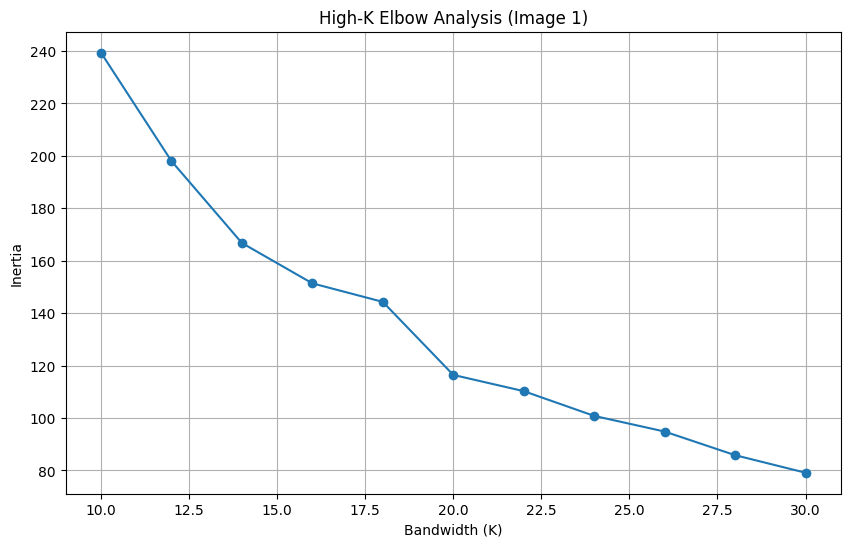

Starting K-Means with K=12...
  -> Converged at iteration 36
Starting K-Means with K=16...
  -> Converged at iteration 93
Starting K-Means with K=20...
  -> Converged at iteration 79
Starting K-Means with K=25...
  -> Converged at iteration 69
Starting K-Means with K=30...
  -> Converged at iteration 142


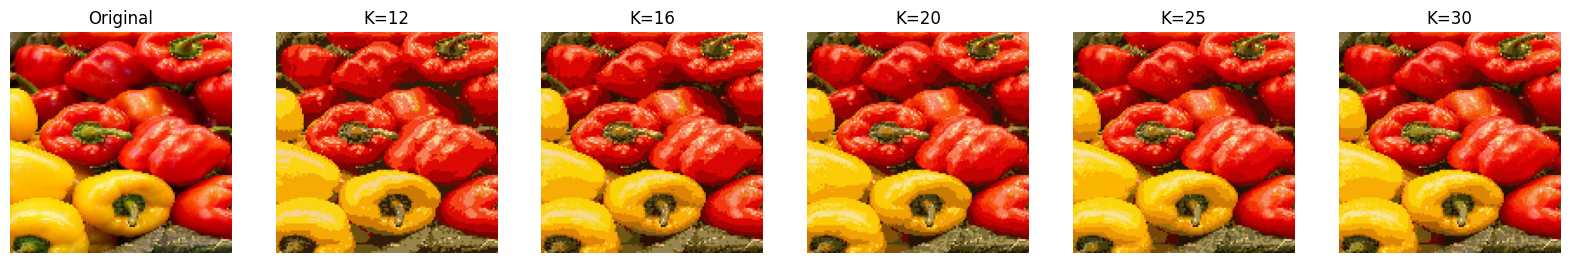


High-K experiment complete.


In [18]:
# -------------------------------------------------------
# HIGH-K EXPERIMENT: Exploring Diminishing Returns
# -------------------------------------------------------

high_k_values = list(range(10, 31, 2))
test_image_id = 1

print("Running High-K Exploration...")
print("Testing K values:", high_k_values)

# One image for detailed high-K analysis
path = f"{base_path}/image_{test_image_id}.png"
image = io.imread(path)
image = np.array(image, dtype=np.float64) / 255.0
if image.shape[2] == 4:
    image = image[:, :, :3]

h, w, c = image.shape
X = image.reshape(-1, 3)

# ---- Inertia computation ----
high_k_inertias = []

for k in high_k_values:
    print(f"\nRunning K-Means with K={k} ...")
    centroids, labels = kmeans_algorithm(X, k, max_iters=150)

    inertia = calculate_inertia(X, centroids, labels)
    high_k_inertias.append(inertia)

    print(f"Inertia for K={k}: {inertia:.2f}")

# ---- Plot High-K Elbow ----
plt.figure(figsize=(10, 6))
plt.plot(high_k_values, high_k_inertias, marker="o")
plt.xlabel("Bandwidth (K)")
plt.ylabel("Inertia")
plt.title(f"High-K Elbow Analysis (Image {test_image_id})")
plt.grid(True)
plt.show()

# -------------------------------------------------------
# VISUAL CHECK: Compare very large K reconstructions
# -------------------------------------------------------

visual_high_k = [12, 16, 20, 25, 30]

plt.figure(figsize=(20, 4))

plt.subplot(1, len(visual_high_k) + 1, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

for i, k in enumerate(visual_high_k):
    centroids, labels = kmeans_algorithm(X, k, max_iters=150)

    recon_flat = centroids[labels.astype(int)]
    recon_img = recon_flat.reshape(h, w, c)

    plt.subplot(1, len(visual_high_k) + 1, i + 2)
    plt.imshow(recon_img)
    plt.title(f"K={k}")
    plt.axis("off")

plt.show()

print("\nHigh-K experiment complete.")

## High-K Results Analysis

### Quantitative Inertia Trends

For the extended experiment with large numbers of clusters, the measured inertia values decreased steadily as \(K\) increased from 10 to 30.

However, the slope of the curve becomes progressively smaller.

The reduction pattern can be interpreted using the K-Means objective:

$$
J(K) = \sum_{i=1}^{N} \|x_i - \mu_{z_i}\|^2
$$

When \(K\) is moderate, new centroids still capture previously unmodeled dominant color groups, producing noticeable drops in error.

At larger values of \(K\), most major color modes are already represented.  
Additional centroids only split existing clusters into nearby sub-clusters, so the reduction in reconstruction error becomes incremental rather than dramatic.

From the numerical results:

- At K = 10, inertia was 243.58  
- At K = 20, inertia was 121.39  
- At K = 30, inertia was 82.55  

This shows that doubling K from 10 to 20 produced a large decrease, whereas increasing K further from 20 to 30 gave a much smaller improvement.

The point where improvement slows significantly occurs around:

$$
K \approx 18 \text{ to } 22
$$

which marks a second saturation region for large-K behavior.

---

### Visual Behavior at Very Large K

Inspection of the reconstructed images confirms the numerical trends:

- At K = 12, reconstructions already appear very close to the original image.
- Increasing K to 20 or higher mainly smooths color gradients and removes small quantization artifacts.
- Between K = 25 and K = 30, changes are barely perceptible.
- Object boundaries and global structure remain nearly unchanged beyond K ≈ 15.

Thus, visually meaningful improvements saturate well before K reaches 30.

---

### Convergence Behavior and Computational Cost

The iteration logs show that convergence requires more steps as K increases:

- Moderate K values converged in roughly 40–70 iterations.
- For K ≥ 24, some runs required more than 100 iterations.

This occurs because:

- The optimization problem becomes higher-dimensional.
- Each centroid controls a smaller set of pixels, making assignments unstable between iterations.
- Nearby centroids compete for similar pixels, slowing stabilization.

Therefore, large K values increase both runtime and memory cost while delivering only marginal gains in visual quality.

---

### Summary of High-K Findings

- Inertia decreases monotonically as K increases.
- The rate of decrease becomes very small beyond roughly K = 20.
- Visual improvements saturate around K = 15 to 20.
- Convergence time grows rapidly for large K.
- Extremely large K values are inefficient under bandwidth constraints.

These results reinforce that while increasing K always improves reconstruction mathematically, the practical benefits diminish once major color structures have already been modeled.
